# Topic modeling example

This exercise introduces topic modeling using the LDA (Latent Dirichlet Allocation) algorithm and the Non-negative Matrix Factorisation (NMF) algorithm.

Topic modeling is an unsupervised approach that allows you to explore large text collections.

In this example, we use the gensim LDA and pyLDAvis implementations for one type of analysis, as well as the sklearn implementations of LDA and NMF to look at how the models relate to categories in the data. 

The main packages that are used in this example are:

nltk: http://www.nltk.org/ - for preprocessing

gensim: https://radimrehurek.com/gensim/ - for building the LDA model

pyLDAvis: https://github.com/bmabey/pyLDAvis - for visualization and easier exploration of the generated topics

sklearn: https://scikit-learn.org/stable/, https://scikit-learn.org/stable/modules/decomposition.html#nmf - for building LDA and NMF models

The example is inspired by, and uses functions from: http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/Gensim%20Newsgroup.ipynb
and
https://github.com/derekgreene/topic-model-tutorial/blob/master/2%20-%20NMF%20Topic%20Models.ipynb

Written by: Sumithra Velupillai, with input from Sonia Priou, February 2019 

In [1]:
## First we need to import all the necessary packages

# There is an incompatibility between the current pyLDAvis and pandas,
# we will downgrade to solve it
#!pip install --upgrade pyLDAvis==2.1.2

import string
from gensim import models
from gensim.corpora import Dictionary, MmCorpus
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import itertools
import zipfile

try:
    import pyLDAvis
except ImportError as e:
    !pip install pyldavis
    import pyLDAvis

import pyLDAvis.gensim as gensimvis
import os
import pandas as pd

import re
import codecs
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

import numpy as np
from sklearn.decomposition import NMF, LatentDirichletAllocation
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings; warnings.simplefilter('ignore')

from datetime import datetime
print(datetime.now())


/opt/anaconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.24.3) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package punkt to /Users/lilifang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lilifang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias fo

2023-02-05 22:23:31.066846


# 1: corpus
The first step in building a topic model is to read a corpus, or a collection of documents.

In this example, we are using documents from http://www.mtsamples.com/. 

These are transcribed medical transcriptions sample reports and examples from a variety of clinical disciplines, such as radiology, surgery, discharge summaries. Note that one document can belong to several categories. 

We will save each document, all its words, and which clinical specialty it belongs to, in a dataframe.


### Just try to export the LIWC words based on words categories


In [3]:
# liwc_df = pd.read_csv('LIWC2015_EN_all_word_category_pair.csv')
# print(liwc_df.shape)

# affect_lis =list(liwc_df[liwc_df['category']=='affect']['words'])
# print(len(affect_lis))

# cognition_lis = list(liwc_df[liwc_df['category']=='cogproc']['words'])
# print(len(cognition_lis))

# percept_lis = list(liwc_df[liwc_df['category']=='percept']['words'])
# print(len(percept_lis))

# social_lis = list(liwc_df[liwc_df['category']=='social']['words'])
# print(len(social_lis))

# all_liwc_lis = list(set(affect_lis+cognition_lis+percept_lis+social_lis))
# print(len(all_liwc_lis))
# print(all_liwc_lis)

# 3 Using sklearn and comparing with 'existing' categories

Now you have seen how you can build a topic models with gensim and look at the contents visually with pyLDAVis.

You can also use sklearn for topic modeling, both lda and nmf, and analyse results visually by comparing with existing categories, if you have them.

NMF approaches can be very efficient, particularly with smaller datasets. Let's see what you think.



In [4]:
def get_tfidf_model(dataframe, text_column, min_df = 5, max_df=100000):
    stopwords = nltk.corpus.stopwords.words('english')
    new_stopwords = ["um", "ok", "oh", "okay", "yes","get","mhm","yeah","ah","uh"]
    stopwords.extend(new_stopwords)
    min_df = 5
    max_df = 100000
    bow_transformer = CountVectorizer(stop_words=stopwords, 
                                  min_df=min_df, 
                                  max_df=max_df).fit(dataframe[text_column])
    document_bow = bow_transformer.transform(dataframe[text_column])
    feature_names = bow_transformer.get_feature_names()
    tfidf_transformer = TfidfTransformer().fit(document_bow)
    document_tfidf= tfidf_transformer.transform(document_bow)
    return feature_names, document_tfidf

In [5]:
def getNMFModel(no_topics, document_tfidf):
    nmf = NMF(n_components=no_topics, 
          random_state=1, 
          alpha=.1, 
          l1_ratio=.5, 
          init='nndsvd').fit(document_tfidf)

    W = nmf.transform(document_tfidf)
    H = nmf.components_
    return nmf, W, H

def getLDAModel(no_topics, document_tfidf):
    lda = LatentDirichletAllocation(n_components=no_topics).fit(document_tfidf)
    return lda

In [6]:
# We need a couple of functions to visualise the data
# Preparation for visualisation 
# Written by Sonia Priou, adaptations by Sumithra Velupillai

def display_topics(model, feature_names, no_top_words):
    topic_id_text_lis = [] 
    for topic_idx, topic in enumerate(model.components_):
        topic_id =topic_idx
        topic_keyword =" - ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        print(topic_id,topic_keyword)
        new_id_keywords = str(topic_id)+':'+topic_keyword
        topic_id_text_lis.append(new_id_keywords)
    return topic_id_text_lis

In [7]:

def get_topic_list(model, feature_names, no_top_words):
    tlist = {}
    for topic_idx, topic in enumerate(model.components_):
        tlist[topic_idx]= str("%d: " % (topic_idx)+", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
    return tlist

    
def display_topic_representation (model,dataframe,tlist):
    doc_topic = model    #example : model = lda_Tfidf.transform(tfidf)
    doc = np.arange(doc_topic.shape[0])
    num_topics = doc_topic.shape[1]
    dico = {'index': doc}
    for n in range(num_topics):
        dico["topic" + str(n)] = doc_topic[:,n]
    
    #Max topic 
    Topic_max = []
    for i in range(doc_topic.shape[0]):
        if len(set(doc_topic[i])) == 1:
            Topic_max.append(num_topics+1)
        else:
            Topic_max.append(doc_topic[i].argmax())
    dico["Topic most represented"] = Topic_max
    #print(Topic_max)
    tlist[num_topics+1] = 'NONE'
    dico["Topic and its most representative words"] = [tlist[x] for x in Topic_max]
    df_topic = pd.DataFrame(dico)

    
    #Link both DataFrame
    df_result = pd.merge(dataframe,df_topic, on='index')
    df_result = df_result.sort_values('Topic most represented')
    
    #Finding within the cluster found by LDA the original file
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    sns.set_style('whitegrid')
    sns.countplot(y='Topic and its most representative words', data = df_result)
    return df_result



In [8]:
def display_file_representation (model,dataframe):
    #Within a file, what is the slipt between topics found
    doc_topic = model    #example : model = lda_Tfidf.transform(tfidf)
    doc = np.arange(doc_topic.shape[0])
    no_topics = doc_topic.shape[1]
    topic = np.arange(no_topics)
    dico = {'index': doc}
    for n in range(no_topics):
        dico["topic" + str(n)] = doc_topic[:,n]
    #Max topic 
    Topic_max = []
    for i in range(doc_topic.shape[0]):
        Topic_max.append(doc_topic[i].argmax())
    dico["Topic most represented"] = Topic_max
    df_topic = pd.DataFrame(dico)
    #print(df_topic)
    
    
    #Link both DataFrame
    df_result = pd.merge(dataframe,df_topic, on='index')
    
    dico2 = {'Topic': topic}
    for i in df_result['label'].value_counts().index:
        ser = df_result.loc[df_result['label']==i].mean()
        score = ser[2:no_topics+2]
        dico2[i]=score

    df_score = pd.DataFrame(dico2)
    print('For each given file, we calculate the mean percentage of the documents depence to each topic')
    print('')
    print(df_score)
    print(df_result['label'].value_counts().index)

    fig, axs = plt.subplots(ncols=len(dataframe['label'].value_counts()))
    count = 0
    for i in df_result['label'].value_counts().index:
        sns.barplot(x='Topic', y =i ,data = df_score, ax=axs[count])
        count = count + 1
        
    plt.tight_layout()

Let's look at a smaller sample, to make the analysis a bit easier. You can choose other categories of course!

Now let's use sklearn's function for converting corpora to document-term-matrices. We'll define a function for this, which takes as parameters a dataframe, the name of the text column that should be transformed to tf-idf, and some optional parameters for thresholds in creating the model. These thresholds can of course be changed!

https://www.projectpro.io/recipes/add-custom-stopwords-and-then-remove-them-from-text

In [9]:
# reload saved data and combine them together

df = pd.read_csv('all_respones_for_all_interviewees_respones_LIWC_words_V2.csv')
#df= df.dropna(subset=['liwc_response'])
print(df.shape)
print(df.columns)

(17953, 8)
Index(['ids', 'diagnosis', 'section', 'pilot_number', 'inter_time', 'response',
       'Nresponse', 'LIWC_response'],
      dtype='object')


In [10]:
def calculate_coherence( w2v_model, term_rankings , print_pairs=False):
        overall_coherence = 0.0
        for topic_index in range(len(term_rankings)):
            # check each pair of terms
            pair_scores = []
            for pair in combinations( term_rankings[topic_index], 2 ):
                ## check if word in vocabulary first!! Added by Sumithra
                if pair[0] in w2v_model.wv.index_to_key and pair[1] in w2v_model.wv.index_to_key:
                    pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
                    if print_pairs:
                        print(pair[0], pair[1], w2v_model.wv.similarity(pair[0], pair[1]))
                else:
                    if print_pairs:
                        print('word pair not in vocabulary', pair[0], pair[1])
                    pair_scores.append( 0.0 )
            # get the mean for all pairs in this topic
            topic_score = sum(pair_scores) / len(pair_scores)
            overall_coherence += topic_score
        # get the mean score across all topics
        return overall_coherence / len(term_rankings)

In [11]:
 class TokenGenerator:
        def __init__( self, documents, stopwords ):
            self.documents = documents
            self.stopwords = stopwords
            self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

        def __iter__( self ):
            #print("Building Word2Vec model ...")
            for doc in self.documents:
                tokens = []
                for tok in self.tokenizer.findall( doc ):
                    if tok.lower() in self.stopwords:
                        tokens.append( "<stopword>" )
                    elif len(tok) >= 2:
                        tokens.append( tok.lower() )
                yield tokens


In [12]:
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

15
0 really - anything - mind - nothing - much - angry - excited - annoying - emotions - annoyed - express - understand - talk - nice - anymore - never - happy - honest - helps - problems
1 like - stuff - things - people - mean - feels - anything - would - said - want - sort - feeling - got - person - talking - going - thing - felt - put - drawing
2 think - anything - actually - trying - might - situation - many - else - remember - things - stuff - thinking - pretty - covered - done - going - told - clearly - moment - happen
3 know - actually - going - mean - want - explain - dont - people - deal - remember - work - anything - already - describe - help - stuff - trying - find - way - express
4 sometimes - angry - want - guess - annoying - depends - tell - might - mean - brother - ask - distracted - helpful - could - annoyed - need - people - shout - annoys - start
5 feel - makes - happy - angry - better - make - sad - upset - emotions - quite - anything - annoyed - way - good - stresse

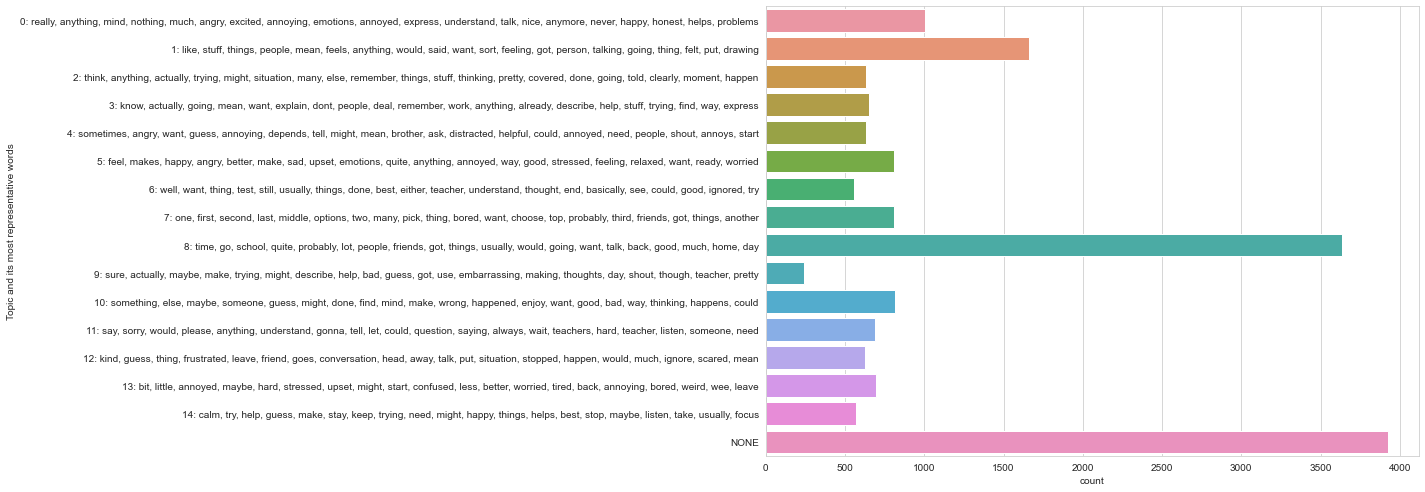

In [22]:
#new_file = open('Best_topic_number_and_topics_response.csv','w')

df['index'] = range(0,len (df))
# Compute coherence score 
import gensim
kmin, kmax = 2, 20
feature_names, document_tfidf = get_tfidf_model(df, 'response')
from sklearn import decomposition
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    #print("Applying NMF for k=%d ..." % k )
    # run NMF
    #model = decomposition.NMF( init="nndsvd", n_components=k ) 
    model = decomposition.NMF( n_components=k, 
          random_state=1, 
          alpha=.1, 
          l1_ratio=.5, 
          init='nndsvd') 
    W = model.fit_transform(document_tfidf )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

stopwords = nltk.corpus.stopwords.words('english')
new_stopwords = ["um", "ok", "oh", "okay", "yes","get","mhm","yeah","ah","uh","no"]
stopwords.extend(new_stopwords)
docgen = TokenGenerator(df['response'], stopwords)
w2v_model = gensim.models.Word2Vec(docgen, min_count=20, sg=1)
from itertools import combinations
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor(feature_names, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    #print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) ) 
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
print(best_k)
#new_file.write(str(item)+','+str(best_k)+'\n')
## let's see if the models produce something coherent with the best_k number
no_topics = best_k
## Each topic is represented with a list of words, ranked according to how discriminative they are for that topic. 
## We can use the top ranked words to try to understand what the topic represents.
no_top_words = 20
#lda = getLDAModel(no_topics, document_tfidf)
nmf, W, H = getNMFModel(no_topics, document_tfidf)
result1= display_topics(nmf, feature_names, no_top_words) 
#new_file.write(str(best_k)+','+str(result1)+'\n')
print('Representation of the main topic for each document')
tlist = get_topic_list(nmf,feature_names, no_top_words)
df_result = display_topic_representation(W,df,tlist)

In [16]:
df_result

,ids,diagnosis,section,pilot_number,inter_time,response,Nresponse,LIWC_response,index,topic0,...,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14,Topic most represented,Topic and its most representative words
949,949,ASD.ADHD,Activity Two,926_05_07_2022,[00:39:17],No not really.,True,not,949,0.107017,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.000000,0,"0: really, anything, mind, nothing, much, angr..."
9915,9915,ADHD,Feedback,Pilot53_07_03_2022,[01:07:19],Definitely too much -- a bit of both because ...,True,because excited really really excited can't re...,9915,0.039262,...,0.0,0.013328,0.0,0.000000,0.0,0.0,0.01544,0.000000,0,"0: really, anything, mind, nothing, much, angr..."
11740,11740,ASD,Activity Three,933_02_07_2022,[00:53:28],Yes it's really easy. I usually have imaginar...,True,really usually people talk,11740,0.021290,...,0.0,0.020412,0.0,0.000000,0.0,0.0,0.00000,0.000000,0,"0: really, anything, mind, nothing, much, angr..."
11739,11739,ASD,Activity Three,933_02_07_2022,[00:53:10],They don't really respond because they don't s...,True,really respond because they express emotions,11739,0.018091,...,0.0,0.007575,0.0,0.000000,0.0,0.0,0.00000,0.001655,0,"0: really, anything, mind, nothing, much, angr..."
8333,8333,ADHD,Activity Two,237_12_05_2022,[00:13:28],Yeah if it's like I've said something and th...,True,if said something nothing changed try ignore l...,8333,0.026405,...,0.0,0.021733,0.0,0.024221,0.0,0.0,0.00000,0.017208,0,"0: really, anything, mind, nothing, much, angr..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7307,7307,ADHD,Activity Three,089_11_04_2022,[01:02:32],Yeah.,False,NaN,7307,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.000000,16,NONE
7304,7304,ADHD,Activity Three,089_11_04_2022,[01:01:27],Yeah.,False,NaN,7304,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.000000,16,NONE
11450,11450,ASD,Activity Two,Pilot18_25_03_2022,[00:18:37],Yeah.,False,NaN,11450,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.000000,16,NONE
11454,11454,ASD,Activity Two,Pilot18_25_03_2022,[00:19:32],Yeah.,False,NaN,11454,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.000000,16,NONE


In [17]:
print(df_result.columns)

Index(['ids', 'diagnosis', 'section', 'pilot_number', 'inter_time', 'response',
       'Nresponse', 'LIWC_response', 'index', 'topic0', 'topic1', 'topic2',
       'topic3', 'topic4', 'topic5', 'topic6', 'topic7', 'topic8', 'topic9',
       'topic10', 'topic11', 'topic12', 'topic13', 'topic14',
       'Topic most represented', 'Topic and its most representative words'],
      dtype='object')


In [18]:
new_df = df_result[['ids', 'diagnosis','section', 'pilot_number', 'inter_time', 'response','LIWC_response','Topic most represented', 'Topic and its most representative words']]

In [19]:
#!pip install xlwt
import xlwt
new_df.to_excel('All interviewees responses and the corresponding representative wordsV3.xlsx',index=False)